In [1]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, BertModel, BertForSequenceClassification, BertTokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Concatenate, GlobalAveragePooling1D
import torch
import torch.nn.functional as F
from torchsummary import summary
import tensorflow as tf
import datasets
import numpy as np
import pandas as pd
from scipy.special import softmax
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from time import time
import gc

## FRENK Dataset

In [2]:
def get_texts(df):
    np_array = df["text"].to_numpy()
    texts = []
    for i in range(len(np_array)):
        texts.append(np_array[i])
    return texts

In [3]:
def truncate(texts,max_length):
    for i in range(len(texts)):
      if len(texts[i]) > max_length:
        texts[i] = texts[i][:max_length]
    return texts

In [4]:
#Save FRENK datasets
ds = datasets.load_dataset("classla/FRENK-hate-en","binary")
df_train = ds["train"].to_pandas()
df_train = df_train[["text","label"]]
df_train.to_csv('data/frenk_train.tsv', sep="\t", index=False)

df_test = ds["test"].to_pandas()
df_test = df_test[["text","label"]]
df_test.to_csv('data/frenk_test.tsv', sep="\t", index=False)

In [5]:
df_train = pd.read_csv('data/frenk_train.tsv',sep='\t')
frenk_train = get_texts(df_train)
frenk_label_train = df_train["label"].to_numpy()

df_test = pd.read_csv('data/frenk_test.tsv',sep='\t')
frenk_test = get_texts(df_test)
frenk_label_test = df_test["label"].to_numpy()

1936


<Axes: >

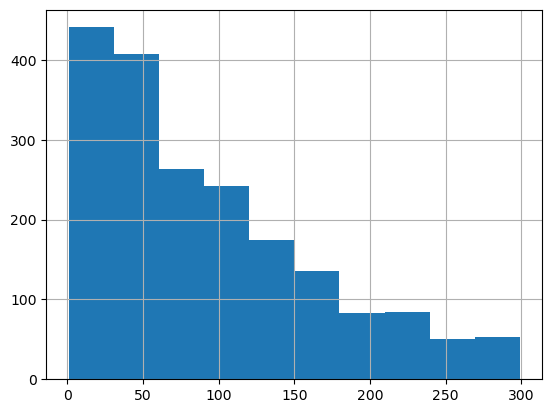

In [6]:
length_test_sent = []
for i in range(len(frenk_test)):
    if len(frenk_test[i])<300:
        length_test_sent.append(len(frenk_test[i]))
print(len(length_test_sent))
pd.Series(length_test_sent).hist()

In [7]:
max_length = 150
frenk_train = truncate(frenk_train,max_length)
frenk_test = truncate(frenk_test,max_length)

In [6]:
print(np.array(frenk_test).shape)

(2301,)


In [7]:
frenk_cweights = compute_class_weight('balanced', classes=np.unique(frenk_label_train), y=frenk_label_train)
frenk_cweights = {0:frenk_cweights[0],1: frenk_cweights[1]}

## Gab Dataset

In [8]:
def get_texts(df):
    np_array = df["text"].to_numpy()
    texts = []
    for i in range(len(np_array)):
        texts.append(np_array[i])
    return texts

In [9]:
def get_hate_labels(labels):
    hate_labels = np.zeros(len(labels))
    for i in range(len(labels)):
        if labels[i].any():
            hate_labels[i] = 1
    return hate_labels

In [10]:
#Gab dataset
df_train = pd.read_csv('data/ghc_train.tsv',sep='\t')
ghc_train = get_texts(df_train)
labels = df_train[["hd","cv","vo"]].to_numpy()
ghc_label_train = get_hate_labels(labels)

df_test = pd.read_csv('data/ghc_test.tsv',sep='\t')
ghc_test = get_texts(df_test)
labels = df_test[["hd","cv","vo"]].to_numpy()
ghc_label_test = get_hate_labels(labels)

In [11]:
max_length = 150
ghc_train = truncate(ghc_train,max_length)
ghc_test = truncate(ghc_test,max_length)

In [12]:
ghc_cweights = compute_class_weight('balanced', classes=np.unique(ghc_label_train), y=ghc_label_train)
ghc_cweights = {0:ghc_cweights[0],1: ghc_cweights[1]}

## Twi-Red-You dataset

In [12]:
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()
df_hate = df[['text','hate_speech_score']]
df_hate['hate'] = (df_hate['hate_speech_score']>=0.5).astype(int)
df_hate = df_hate[['text','hate']]

df_hate_train = df_hate.iloc[0:8404]
df_hate_test = df_hate.iloc[8404:8404+2301]

df_hate_train.to_csv('data/try_train_8404.tsv', sep="\t", index=False)
df_hate_test.to_csv('data/try_test_2301.tsv', sep="\t", index=False)

Found cached dataset parquet (C:/Users/Pedro/.cache/huggingface/datasets/ucberkeley-dlab___parquet/ucberkeley-dlab--measuring-hate-speech-c32713cabe528196/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Pedro\AppData\Local\Temp\ipykernel_16336\1110734405.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hate['hate'] = (df_hate['hate_speech_score']>=0.5).astype(int)


In [8]:
#Twi-Red-You dataset
df_train = pd.read_csv('data/try_train_8404.tsv',sep='\t')
try_train = get_texts(df_train)
try_label_train = df_train['hate'].to_numpy()

df_test = pd.read_csv('data/try_test_2301.tsv',sep='\t')
try_test = get_texts(df_test)
try_label_test = df_test['hate'].to_numpy()

In [14]:
max_length = 150
try_train = truncate(try_train,max_length)
try_test = truncate(try_test,max_length)

In [15]:
try_cweights = compute_class_weight('balanced', classes=np.unique(try_label_train), y=try_label_train)
try_cweights = {0:try_cweights[0], 1:try_cweights[1]}

## Load models

In [16]:
#roBERTa models
sent_MOD = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
aggr_MOD = f"cardiffnlp/twitter-roberta-base-offensive"
gen_MOD = f"roberta-base"

#Load tokenizer and models
tokenizer = AutoTokenizer.from_pretrained(sent_MOD)
sent_mod = TFAutoModel.from_pretrained(sent_MOD)
aggr_mod = TFAutoModel.from_pretrained(aggr_MOD)
gen_mod = TFAutoModel.from_pretrained(gen_MOD)

batch_size = 32

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-offensive were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel

In [17]:
def Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out_1 = []
  batch_out_2 = []
  batch_out_3 = []
  for batch in batches:
      encoded_inputs = tokenizer(batch,padding=True,return_tensors='tf')
      # Compute the outputs of the modules as numpy arrays.
      emb_1 = sent_mod(encoded_inputs)[0]
      pool_1 = GlobalAveragePooling1D()(emb_1).numpy()
      batch_out_1.append(pool_1)

      emb_2 = aggr_mod(encoded_inputs)[0]
      pool_2 = GlobalAveragePooling1D()(emb_2).numpy()
      batch_out_2.append(pool_2)

      emb_3 = gen_mod(encoded_inputs)[0]
      pool_3 = GlobalAveragePooling1D()(emb_3).numpy()
      batch_out_3.append(pool_3)    
    
      encoded_inputs = None
      emb_1 = None
      emb_2 = None
      emb_3 = None
      gc.collect() 
    
  outs_1 = np.concatenate(batch_out_1,axis=0)
  outs_2 = np.concatenate(batch_out_2,axis=0)
  outs_3 = np.concatenate(batch_out_3,axis=0)  

  return outs_1,outs_2,outs_3

## Compute outputs (If the outputs are already saved you can skip this step)

### FRENK dataset

In [19]:
#### Train set
t = time()
outs_sent,outs_aggr,outs_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,frenk_train,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/frenk/sent_train_outs.npy',outs_sent)
np.save('outs/frenk/aggr_train_outs.npy',outs_aggr)
np.save('outs/frenk/gen_train_outs.npy',outs_gen)

Elapsed time: 182.81349110603333


In [20]:
#### Test set
t = time()
outs_sent,outs_aggr,outs_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,frenk_test,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/frenk/sent_test_outs.npy',outs_sent)
np.save('outs/frenk/aggr_test_outs.npy',outs_aggr)
np.save('outs/frenk/gen_test_outs.npy',outs_gen)

Elapsed time: 47.71849966049194


### Gab dataset

In [21]:
#### Train set
batch_size = 32

t = time()
outs_sent,outs_aggr,outs_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,ghc_train,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/ghc/sent_train_outs.npy',outs_sent)
np.save('outs/ghc/aggr_train_outs.npy',outs_aggr)
np.save('outs/ghc/gen_train_outs.npy',outs_gen)

Elapsed time: 467.4172308444977


In [22]:
#### Test set
t = time()
outs_sent,outs_aggr,outs_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,ghc_test,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/ghc/sent_test_outs.npy',outs_sent)
np.save('outs/ghc/aggr_test_outs.npy',outs_aggr)
np.save('outs/ghc/gen_test_outs.npy',outs_gen)

Elapsed time: 117.57411527633667


### Twi-Red-You dataset

In [23]:
#### Train set
batch_size = 32

t = time()
outs_sent,outs_aggr,outs_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,try_train,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/try/sent_train_outs.npy',outs_sent)
np.save('outs/try/aggr_train_outs.npy',outs_aggr)
np.save('outs/try/gen_train_outs.npy',outs_gen)

Elapsed time: 166.6827666759491


In [24]:
#### Test set
t = time()
outs_sent,outs_aggr,outs_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,try_test,batch_size)
print("Elapsed time:",time()-t)

np.save('outs/try/sent_test_outs.npy',outs_sent)
np.save('outs/try/aggr_test_outs.npy',outs_aggr)
np.save('outs/try/gen_test_outs.npy',outs_gen)

Elapsed time: 44.98300838470459


## Load outputs

In [18]:
frenk_sent_train = np.load('outs/frenk/sent_train_outs.npy')
frenk_aggr_train = np.load('outs/frenk/aggr_train_outs.npy')
frenk_gen_train = np.load('outs/frenk/gen_train_outs.npy')

frenk_sent_test = np.load('outs/frenk/sent_test_outs.npy')
frenk_aggr_test = np.load('outs/frenk/aggr_test_outs.npy')
frenk_gen_test = np.load('outs/frenk/gen_test_outs.npy')

In [19]:
ghc_sent_train = np.load('outs/ghc/sent_train_outs.npy')
ghc_aggr_train = np.load('outs/ghc/aggr_train_outs.npy')
ghc_gen_train = np.load('outs/ghc/gen_train_outs.npy')

ghc_sent_test = np.load('outs/ghc/sent_test_outs.npy')
ghc_aggr_test = np.load('outs/ghc/aggr_test_outs.npy')
ghc_gen_test = np.load('outs/ghc/gen_test_outs.npy')

In [20]:
try_sent_train = np.load('outs/try/sent_train_outs.npy')
try_aggr_train = np.load('outs/try/aggr_train_outs.npy')
try_gen_train = np.load('outs/try/gen_train_outs.npy')

try_sent_test = np.load('outs/try/sent_test_outs.npy')
try_aggr_test = np.load('outs/try/aggr_test_outs.npy')
try_gen_test = np.load('outs/try/gen_test_outs.npy')

In [21]:
print(try_sent_train.shape)

(8404, 768)


## Hate prediction with the 3 models

In [22]:
conc_frenk_train = np.concatenate([frenk_sent_train, frenk_aggr_train, frenk_gen_train], axis=1)
conc_frenk_test = np.concatenate([frenk_sent_test, frenk_aggr_test, frenk_gen_test], axis=1)

In [23]:
conc_ghc_train = np.concatenate([ghc_sent_train, ghc_aggr_train, ghc_gen_train], axis=1)
conc_ghc_test = np.concatenate([ghc_sent_test, ghc_aggr_test, ghc_gen_test], axis=1)

In [24]:
conc_ghc_train = conc_ghc_train[:8404]
conc_ghc_test = conc_ghc_test[:2301]

ghc_gen_train = ghc_gen_train[:8404]
ghc_gen_test = ghc_gen_test[:2301]

ghc_label_train = ghc_label_train[:8404]
ghc_label_test = ghc_label_test[:2301]

In [25]:
conc_try_train = np.concatenate([try_sent_train, try_aggr_train, try_gen_train], axis=1)
conc_try_test = np.concatenate([try_sent_test, try_aggr_test, try_gen_test], axis=1)

In [26]:
print(conc_try_train.shape)

(8404, 2304)


In [27]:
##Counterfactual evaluation
def evaluate_text_PEACE(text,model,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size):
    out_sent,out_aggr,out_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,text,batch_size)
    conc = np.concatenate([out_sent,out_aggr,out_gen],axis=1)
    prob = model.predict(conc)
    print("Hate prob.:",prob)

In [28]:
n_avg = 1

### Training with FRENK

In [29]:
acc_train = []
f1_train = []
acc_test = []
f1_test = []
acc_test_ghc = []
f1_test_ghc = []
acc_test_try = []
f1_test_try = []
for i in range(n_avg):
    hate_model = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model.fit(conc_frenk_train, frenk_label_train, class_weight=frenk_cweights, epochs=5, batch_size=32)
    #class_weight=frenk_cweights

    probs = hate_model.predict(conc_frenk_train)
    preds = (probs >= 0.5).astype(int)
    acc_train.append(metrics.accuracy_score(preds,frenk_label_train))
    f1_train.append(metrics.f1_score(preds,frenk_label_train,zero_division=1))

    probs = hate_model.predict(conc_frenk_test)
    preds = (probs >= 0.5).astype(int)
    acc_test.append(metrics.accuracy_score(preds,frenk_label_test))
    f1_test.append(metrics.f1_score(preds,frenk_label_test,zero_division=1))
    
    probs = hate_model.predict(conc_ghc_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_ghc.append(metrics.accuracy_score(preds,ghc_label_test))
    f1_test_ghc.append(metrics.f1_score(preds,ghc_label_test,zero_division=1))
    
    probs = hate_model.predict(conc_try_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_try.append(metrics.accuracy_score(preds,try_label_test))
    f1_test_try.append(metrics.f1_score(preds,try_label_test,zero_division=1))

Epoch 1/5
263/263 [==============================] - 1s 2ms/step - loss: 0.5291 - accuracy: 0.7244
Epoch 2/5
263/263 [==============================] - 1s 2ms/step - loss: 0.4928 - accuracy: 0.7450
Epoch 3/5
263/263 [==============================] - 1s 2ms/step - loss: 0.4777 - accuracy: 0.7536
Epoch 4/5
263/263 [==============================] - 1s 2ms/step - loss: 0.4678 - accuracy: 0.7530
Epoch 5/5
72/72 [==============================] - 0s 763us/step


In [30]:
print("Train set:")
print("Avg. accuracy:",np.mean(acc_train))
print("Avg. f1 score:",np.mean(f1_train))

Train set:
Avg. accuracy: 0.76713469776297
Avg. f1 score: 0.729059947390281


In [31]:
print("FRENK Test set:")
print("Avg. accuracy:",np.mean(acc_test))
print("Avg. f1 score:",np.mean(f1_test))

FRENK Test set:
Avg. accuracy: 0.7440243372446762
Avg. f1 score: 0.7111329082883766


In [32]:
print("Gab Test set:")
print("Avg. accuracy:",np.mean(acc_test_ghc))
print("Avg. f1 score:",np.mean(f1_test_ghc))

Gab Test set:
Avg. accuracy: 0.6001738374619731
Avg. f1 score: 0.3437945791726105


In [33]:
print("Twi-Red-You Test set:")
print("Avg. accuracy:",np.mean(acc_test_try))
print("Avg. f1 score:",np.mean(f1_test_try))

Twi-Red-You Test set:
Avg. accuracy: 0.549760973489787
Avg. f1 score: 0.5399644760213145


In [34]:
text = ["We are ALL tired of waiting . . realize something"]
text_aggr = ["We’ve had ENOUGH of your delays. Get your act together NOW"]

evaluate_text_PEACE(text,hate_model,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)
evaluate_text_PEACE(text_aggr,hate_model,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)

1/1 [==============================] - 0s 20ms/step
Hate prob.: [[0.5601345]]
1/1 [==============================] - 0s 19ms/step
Hate prob.: [[0.790452]]


### Training with Gab

In [35]:
acc_train = []
f1_train = []
acc_test = []
f1_test = []
acc_test_frenk = []
f1_test_frenk = []
acc_test_try = []
f1_test_try = []
for i in range(n_avg):
    hate_model = Sequential([
          Flatten(),
          Dense(32, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model.fit(conc_ghc_train, ghc_label_train, class_weight=ghc_cweights, epochs=5, batch_size=32)

    probs = hate_model.predict(conc_ghc_train)
    preds = (probs >= 0.5).astype(int)
    acc_train.append(metrics.accuracy_score(preds,ghc_label_train))
    f1_train.append(metrics.f1_score(preds,ghc_label_train,zero_division=1))

    probs = hate_model.predict(conc_ghc_test)
    preds = (probs >= 0.5).astype(int)
    acc_test.append(metrics.accuracy_score(preds,ghc_label_test))
    f1_test.append(metrics.f1_score(preds,ghc_label_test,zero_division=1))
    
    probs = hate_model.predict(conc_frenk_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_frenk.append(metrics.accuracy_score(preds,frenk_label_test))
    f1_test_frenk.append(metrics.f1_score(preds,frenk_label_test,zero_division=1))
    
    probs = hate_model.predict(conc_try_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_try.append(metrics.accuracy_score(preds,try_label_test))
    f1_test_try.append(metrics.f1_score(preds,try_label_test,zero_division=1))

Epoch 1/5
263/263 [==============================] - 1s 1ms/step - loss: 0.4636 - accuracy: 0.7764
Epoch 2/5
263/263 [==============================] - 0s 1ms/step - loss: 0.4308 - accuracy: 0.7890
Epoch 3/5
263/263 [==============================] - 0s 1ms/step - loss: 0.4092 - accuracy: 0.8007
Epoch 4/5
263/263 [==============================] - 0s 1ms/step - loss: 0.3948 - accuracy: 0.7980
Epoch 5/5
72/72 [==============================] - 0s 611us/step


In [36]:
print("Train set:")
print("Avg. accuracy:",np.mean(acc_train))
print("Avg. f1 score:",np.mean(f1_train))

Train set:
Avg. accuracy: 0.8123512613041409
Avg. f1 score: 0.5419692128957304


In [37]:
print("Gab Test set:")
print("Avg. accuracy:",np.mean(acc_test))
print("Avg. f1 score:",np.mean(f1_test))

Gab Test set:
Avg. accuracy: 0.7705345501955672
Avg. f1 score: 0.4645030425963489


In [38]:
print("FRENK Test set:")
print("Avg. accuracy:",np.mean(acc_test_frenk))
print("Avg. f1 score:",np.mean(f1_test_frenk))

FRENK Test set:
Avg. accuracy: 0.732290308561495
Avg. f1 score: 0.6414435389988358


In [39]:
print("Twi-Red-You Test set:")
print("Avg. accuracy:",np.mean(acc_test_try))
print("Avg. f1 score:",np.mean(f1_test_try))

Twi-Red-You Test set:
Avg. accuracy: 0.5045632333767927
Avg. f1 score: 0.5169491525423728


In [40]:
text = ["We are ALL tired of waiting . . realize something"]
text_aggr = ["We’ve had ENOUGH of your delays. Get your act together NOW"]

evaluate_text_PEACE(text,hate_model,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)
evaluate_text_PEACE(text_aggr,hate_model,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)

1/1 [==============================] - 0s 16ms/step
Hate prob.: [[0.09370035]]
1/1 [==============================] - 0s 17ms/step
Hate prob.: [[0.27734035]]


### Training with Twi-Red-You

In [41]:
acc_train = []
f1_train = []
acc_test = []
f1_test = []
acc_test_frenk = []
f1_test_frenk = []
acc_test_ghc = []
f1_test_ghc = []
for i in range(n_avg):
    hate_model = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model.fit(conc_try_train, try_label_train, class_weight=try_cweights, epochs=5, batch_size=32)

    probs = hate_model.predict(conc_try_train)
    preds = (probs >= 0.5).astype(int)
    acc_train.append(metrics.accuracy_score(preds,try_label_train))
    f1_train.append(metrics.f1_score(preds,try_label_train,zero_division=1))
    
    probs = hate_model.predict(conc_try_test)
    preds = (probs >= 0.5).astype(int)
    acc_test.append(metrics.accuracy_score(preds,try_label_test))
    f1_test.append(metrics.f1_score(preds,try_label_test,zero_division=1))

    probs = hate_model.predict(conc_frenk_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_frenk.append(metrics.accuracy_score(preds,frenk_label_test))
    f1_test_frenk.append(metrics.f1_score(preds,frenk_label_test,zero_division=1))
    
    probs = hate_model.predict(conc_ghc_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_ghc.append(metrics.accuracy_score(preds,ghc_label_test))
    f1_test_ghc.append(metrics.f1_score(preds,ghc_label_test,zero_division=1))

Epoch 1/5
263/263 [==============================] - 1s 2ms/step - loss: 0.4878 - accuracy: 0.7479
Epoch 2/5
263/263 [==============================] - 1s 2ms/step - loss: 0.4598 - accuracy: 0.7630
Epoch 3/5
263/263 [==============================] - 1s 2ms/step - loss: 0.4421 - accuracy: 0.7731
Epoch 4/5
263/263 [==============================] - 2s 7ms/step - loss: 0.4295 - accuracy: 0.7858
Epoch 5/5
72/72 [==============================] - 0s 986us/step


In [42]:
print("Train set:")
print("Avg. accuracy:",np.mean(acc_train))
print("Avg. f1 score:",np.mean(f1_train))

Train set:
Avg. accuracy: 0.8281770585435507
Avg. f1 score: 0.7067424857839155


In [43]:
print("Twi-Red-You Test set:")
print("Avg. accuracy:",np.mean(acc_test))
print("Avg. f1 score:",np.mean(f1_test))

Twi-Red-You Test set:
Avg. accuracy: 0.7879182963928727
Avg. f1 score: 0.6509298998569384


In [44]:
print("FRENK Test set:")
print("Avg. accuracy:",np.mean(acc_test_frenk))
print("Avg. f1 score:",np.mean(f1_test_frenk))

FRENK Test set:
Avg. accuracy: 0.6649282920469362
Avg. f1 score: 0.2867715078630897


In [45]:
print("Gab Test set:")
print("Avg. accuracy:",np.mean(acc_test_ghc))
print("Avg. f1 score:",np.mean(f1_test_ghc))

Gab Test set:
Avg. accuracy: 0.8400695349847892
Avg. f1 score: 0.2698412698412698


In [46]:
text = ["We are ALL tired of waiting . . realize something"]
text_aggr = ["We’ve had ENOUGH of your delays. Get your act together NOW"]

evaluate_text_PEACE(text,hate_model,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)
evaluate_text_PEACE(text_aggr,hate_model,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)

1/1 [==============================] - 0s 15ms/step
Hate prob.: [[0.18634619]]
1/1 [==============================] - 0s 15ms/step
Hate prob.: [[0.32117924]]


## Hate prediction with the general model

In [47]:
##Counterfactual evaluation
def evaluate_text_gen(text,model,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size):
    _,_,out_gen = Compute_Embeddings(tokenizer,sent_mod,aggr_mod,gen_mod,text,batch_size)
    prob = model.predict(out_gen)
    print("Hate prob.:",prob)

### Training with FRENK

In [48]:
acc_train = []
f1_train = []
acc_test = []
f1_test = []
acc_test_ghc = []
f1_test_ghc = []
acc_test_try = []
f1_test_try = []
for i in range(n_avg):
    hate_model_gen = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model_gen.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model_gen.fit(frenk_gen_train, frenk_label_train, class_weight=frenk_cweights, epochs=5, batch_size=32)

    probs = hate_model_gen.predict(frenk_gen_train)
    preds = (probs >= 0.5).astype(int)
    acc_train.append(metrics.accuracy_score(preds,frenk_label_train))
    f1_train.append(metrics.f1_score(preds,frenk_label_train,zero_division=1))

    probs = hate_model_gen.predict(frenk_gen_test)
    preds = (probs >= 0.5).astype(int)
    acc_test.append(metrics.accuracy_score(preds,frenk_label_test))
    f1_test.append(metrics.f1_score(preds,frenk_label_test,zero_division=1))
    
    probs = hate_model_gen.predict(ghc_gen_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_ghc.append(metrics.accuracy_score(preds,ghc_label_test))
    f1_test_ghc.append(metrics.f1_score(preds,ghc_label_test,zero_division=1))
    
    probs = hate_model_gen.predict(try_gen_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_try.append(metrics.accuracy_score(preds,try_label_test))
    f1_test_try.append(metrics.f1_score(preds,try_label_test,zero_division=1))

Epoch 1/5
263/263 [==============================] - 1s 1ms/step - loss: 0.5977 - accuracy: 0.6590
Epoch 2/5
263/263 [==============================] - 0s 1ms/step - loss: 0.5340 - accuracy: 0.7228
Epoch 3/5
263/263 [==============================] - 0s 1ms/step - loss: 0.5052 - accuracy: 0.7394
Epoch 4/5
263/263 [==============================] - 0s 1ms/step - loss: 0.4889 - accuracy: 0.7448
Epoch 5/5
72/72 [==============================] - 0s 702us/step


In [49]:
print("Train set:")
print("Avg. accuracy:",np.mean(acc_train))
print("Avg. f1 score:",np.mean(f1_train))

Train set:
Avg. accuracy: 0.7696335078534031
Avg. f1 score: 0.7323748963229195


In [50]:
print("FRENK Test set:")
print("Avg. accuracy:",np.mean(acc_test))
print("Avg. f1 score:",np.mean(f1_test))

FRENK Test set:
Avg. accuracy: 0.7183833116036505
Avg. f1 score: 0.6845180136319376


In [51]:
print("Gab Test set:")
print("Avg. accuracy:",np.mean(acc_test_ghc))
print("Avg. f1 score:",np.mean(f1_test_ghc))

Gab Test set:
Avg. accuracy: 0.5371577574967406
Avg. f1 score: 0.315112540192926


In [52]:
print("Twi-Red-You Test set:")
print("Avg. accuracy:",np.mean(acc_test_try))
print("Avg. f1 score:",np.mean(f1_test_try))

Twi-Red-You Test set:
Avg. accuracy: 0.5284658843980878
Avg. f1 score: 0.521393912659903


In [53]:
text = ["We are ALL tired of waiting . . realize something"]
text_aggr = ["We’ve had ENOUGH of your delays. Get your act together NOW"]

evaluate_text_gen(text,hate_model_gen,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)
evaluate_text_gen(text_aggr,hate_model_gen,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)

1/1 [==============================] - 0s 15ms/step
Hate prob.: [[0.44473627]]
1/1 [==============================] - 0s 16ms/step
Hate prob.: [[0.80106705]]


### Training with Gab

In [54]:
acc_train = []
f1_train = []
acc_test = []
f1_test = []
acc_test_frenk = []
f1_test_frenk = []
acc_test_try = []
f1_test_try = []
for i in range(n_avg):
    hate_model_gen = Sequential([
          Flatten(),
          Dense(32, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model_gen.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model_gen.fit(ghc_gen_train, ghc_label_train, class_weight=ghc_cweights, epochs=5, batch_size=32)

    probs = hate_model_gen.predict(ghc_gen_train)
    preds = (probs >= 0.5).astype(int)
    acc_train.append(metrics.accuracy_score(preds,ghc_label_train))
    f1_train.append(metrics.f1_score(preds,ghc_label_train,zero_division=1))

    probs = hate_model_gen.predict(ghc_gen_test)
    preds = (probs >= 0.5).astype(int)
    acc_test.append(metrics.accuracy_score(preds,ghc_label_test))
    f1_test.append(metrics.f1_score(preds,ghc_label_test,zero_division=1))
    
    probs = hate_model_gen.predict(frenk_gen_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_frenk.append(metrics.accuracy_score(preds,frenk_label_test))
    f1_test_frenk.append(metrics.f1_score(preds,frenk_label_test,zero_division=1))
    
    probs = hate_model_gen.predict(try_gen_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_try.append(metrics.accuracy_score(preds,try_label_test))
    f1_test_try.append(metrics.f1_score(preds,try_label_test,zero_division=1))

Epoch 1/5
263/263 [==============================] - 1s 942us/step - loss: 0.5781 - accuracy: 0.7045
Epoch 2/5
263/263 [==============================] - 0s 915us/step - loss: 0.4828 - accuracy: 0.7692
Epoch 3/5
263/263 [==============================] - 0s 916us/step - loss: 0.4576 - accuracy: 0.7809
Epoch 4/5
263/263 [==============================] - 0s 935us/step - loss: 0.4458 - accuracy: 0.7901
Epoch 5/5
72/72 [==============================] - 0s 600us/step


In [55]:
print("Train set:")
print("Avg. accuracy:",np.mean(acc_train))
print("Avg. f1 score:",np.mean(f1_train))

Train set:
Avg. accuracy: 0.75571156592099
Avg. f1 score: 0.4811726055092242


In [56]:
print("Gab Test set:")
print("Avg. accuracy:",np.mean(acc_test))
print("Avg. f1 score:",np.mean(f1_test))

Gab Test set:
Avg. accuracy: 0.7166449369839201
Avg. f1 score: 0.4330434782608696


In [57]:
print("FRENK Test set:")
print("Avg. accuracy:",np.mean(acc_test_frenk))
print("Avg. f1 score:",np.mean(f1_test_frenk))

FRENK Test set:
Avg. accuracy: 0.6923076923076923
Avg. f1 score: 0.651231527093596


In [58]:
print("Twi-Red-You Test set:")
print("Avg. accuracy:",np.mean(acc_test_try))
print("Avg. f1 score:",np.mean(f1_test_try))

Twi-Red-You Test set:
Avg. accuracy: 0.44111255975662755
Avg. f1 score: 0.48353413654618477


In [59]:
text = ["We are ALL tired of waiting . . realize something"]
text_aggr = ["We’ve had ENOUGH of your delays. Get your act together NOW"]

evaluate_text_gen(text,hate_model_gen,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)
evaluate_text_gen(text_aggr,hate_model_gen,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)

1/1 [==============================] - 0s 14ms/step
Hate prob.: [[0.11206387]]
1/1 [==============================] - 0s 14ms/step
Hate prob.: [[0.7511092]]


### Training with Twi-Red-You

In [60]:
acc_train = []
f1_train = []
acc_test = []
f1_test = []
acc_test_frenk = []
f1_test_frenk = []
acc_test_ghc = []
f1_test_ghc = []
for i in range(n_avg):
    hate_model_gen = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model_gen.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model_gen.fit(try_gen_train, try_label_train, class_weight=try_cweights, epochs=5, batch_size=32)

    probs = hate_model_gen.predict(try_gen_train)
    preds = (probs >= 0.5).astype(int)
    acc_train.append(metrics.accuracy_score(preds,try_label_train))
    f1_train.append(metrics.f1_score(preds,try_label_train,zero_division=1))
    
    probs = hate_model_gen.predict(try_gen_test)
    preds = (probs >= 0.5).astype(int)
    acc_test.append(metrics.accuracy_score(preds,try_label_test))
    f1_test.append(metrics.f1_score(preds,try_label_test,zero_division=1))
    
    probs = hate_model_gen.predict(frenk_gen_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_frenk.append(metrics.accuracy_score(preds,frenk_label_test))
    f1_test_frenk.append(metrics.f1_score(preds,frenk_label_test,zero_division=1))

    probs = hate_model_gen.predict(ghc_gen_test)
    preds = (probs >= 0.5).astype(int)
    acc_test_ghc.append(metrics.accuracy_score(preds,ghc_label_test))
    f1_test_ghc.append(metrics.f1_score(preds,ghc_label_test,zero_division=1))

Epoch 1/5
263/263 [==============================] - 1s 2ms/step - loss: 0.5421 - accuracy: 0.7010
Epoch 2/5
263/263 [==============================] - 0s 2ms/step - loss: 0.4820 - accuracy: 0.7456
Epoch 3/5
263/263 [==============================] - 0s 2ms/step - loss: 0.4692 - accuracy: 0.7523
Epoch 4/5
263/263 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.7555
Epoch 5/5
72/72 [==============================] - 0s 698us/step


In [61]:
print("Train set:")
print("Avg. accuracy:",np.mean(acc_train))
print("Avg. f1 score:",np.mean(f1_train))

Train set:
Avg. accuracy: 0.7707044264635887
Avg. f1 score: 0.669751499571551


In [62]:
print("Twi-Red-You Test set:")
print("Avg. accuracy:",np.mean(acc_test))
print("Avg. f1 score:",np.mean(f1_test))

Twi-Red-You Test set:
Avg. accuracy: 0.7444589308996089
Avg. f1 score: 0.6343283582089553


In [63]:
print("FRENK Test set:")
print("Avg. accuracy:",np.mean(acc_test_frenk))
print("Avg. f1 score:",np.mean(f1_test_frenk))

FRENK Test set:
Avg. accuracy: 0.6740547588005215
Avg. f1 score: 0.4501466275659824


In [64]:
print("Gab Test set:")
print("Avg. accuracy:",np.mean(acc_test_ghc))
print("Avg. f1 score:",np.mean(f1_test_ghc))

Gab Test set:
Avg. accuracy: 0.7883528900478053
Avg. f1 score: 0.3427800269905533


In [65]:
text = ["We are ALL tired of waiting . . realize something"]
text_aggr = ["We’ve had ENOUGH of your delays. Get your act together NOW"]

evaluate_text_gen(text,hate_model_gen,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)
evaluate_text_gen(text_aggr,hate_model_gen,tokenizer,sent_mod,aggr_mod,gen_mod,batch_size)

1/1 [==============================] - 0s 15ms/step
Hate prob.: [[0.31169623]]
1/1 [==============================] - 0s 15ms/step
Hate prob.: [[0.66351634]]


## HateBERT

In [66]:
model_dir = "HateBERT_hateval"
HateBERT = BertModel.from_pretrained(
    model_dir # Use pre-trained model from its directory, change this to use a pre-trained model from bert
)
HateBERT.eval()
HateBERT_tok = BertTokenizer.from_pretrained(model_dir)

In [71]:
def Comp_Embed_HateBERT(tokenizer,mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out = []

  with torch.no_grad():
      for batch in batches:
          encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')       
          # Compute the output of the module as a numpy array.       
          emb = mod(**encoded_inputs)[0]
          tf_emb = tf.convert_to_tensor(emb.numpy())  
          pool = GlobalAveragePooling1D()(tf_emb).numpy()
          batch_out.append(pool)

          encoded_inputs = None
          tf_emb = None
          gc.collect() 
    
  outs = np.concatenate(batch_out,axis=0)
  return outs

## Compute HateBERT embeddings (If these outputs are already saved you can skip this step)

### FRENK dataset

In [22]:
###Train set
batch_size = 32

t = time()
outs_train = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,frenk_train,batch_size)
print("Elapsed time:",time()-t)
print(outs_train.shape)

np.save('outs/frenk/HateBERT_train_emb.npy',outs_train)


KeyboardInterrupt



In [ ]:
###Test set
t = time()
outs_test = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,frenk_test,batch_size)
print("Elapsed time:",time()-t)
print(outs_test.shape)

np.save('outs/frenk/HateBERT_test_emb.npy',outs_test)

### Gab dataset

In [ ]:
###Train set
batch_size = 32

t = time()
outs_train = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,ghc_train,batch_size)
print("Elapsed time:",time()-t)
print(outs_train.shape)

np.save('outs/ghc/HateBERT_train_emb.npy',outs_train)

In [ ]:
###Test set
t = time()
outs_test = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,ghc_test,batch_size)
print("Elapsed time:",time()-t)
print(outs_test.shape)

np.save('outs/ghc/HateBERT_test_emb.npy',outs_test)

### Twi-Red-You dataset

In [ ]:
###Train set
batch_size = 32

t = time()
outs_train = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,try_train,batch_size)
print("Elapsed time:",time()-t)
print(outs_train.shape)

np.save('outs/try/HateBERT_train_emb.npy',outs_train)

In [ ]:
###Test set
t = time()
outs_test = Comp_Embed_HateBERT(HateBERT_tok,HateBERT,try_test,batch_size)
print("Elapsed time:",time()-t)
print(outs_test.shape)

np.save('outs/try/HateBERT_test_emb.npy',outs_test)

## Hate prediction with HateBERT

In [72]:
frenk_train_emb = np.load('outs/frenk/HateBERT_train_emb.npy')
frenk_test_emb = np.load('outs/frenk/HateBERT_test_emb.npy')

In [73]:
ghc_train_emb = np.load('outs/ghc/HateBERT_train_emb.npy')
ghc_test_emb = np.load('outs/ghc/HateBERT_test_emb.npy')

In [74]:
ghc_train_emb = ghc_train_emb[:8404]
ghc_test_emb = ghc_test_emb[:2301]

In [75]:
try_train_emb = np.load('outs/try/HateBERT_train_emb.npy')
try_test_emb = np.load('outs/try/HateBERT_test_emb.npy')

In [76]:
##Counterfactual evaluation
def evaluate_text_HateBERT(text,model,tokenizer,HateBERT,batch_size):
    out = Comp_Embed_HateBERT(tokenizer,HateBERT,text,batch_size)
    prob = model.predict(out)
    print("Hate prob.:",prob)

### Training with FRENK

In [78]:
n_avg = 1

In [79]:
acc_train = []
f1_train = []
acc_test = []
f1_test = []
acc_test_ghc = []
f1_test_ghc = []
acc_test_try = []
f1_test_try = []
for i in range(n_avg):
    classifier_HateBERT = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    classifier_HateBERT.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    classifier_HateBERT.fit(frenk_train_emb, frenk_label_train, class_weight=frenk_cweights, epochs=5, batch_size=32)

    probs = classifier_HateBERT.predict(frenk_train_emb)
    preds = (probs >= 0.5).astype(int)
    acc_train.append(metrics.accuracy_score(preds,frenk_label_train))
    f1_train.append(metrics.f1_score(preds,frenk_label_train,zero_division=1))

    probs = classifier_HateBERT.predict(frenk_test_emb)
    preds = (probs >= 0.5).astype(int)
    acc_test.append(metrics.accuracy_score(preds,frenk_label_test))
    f1_test.append(metrics.f1_score(preds,frenk_label_test,zero_division=1))
    
    probs = classifier_HateBERT.predict(ghc_test_emb)
    preds = (probs >= 0.5).astype(int)
    acc_test_ghc.append(metrics.accuracy_score(preds,ghc_label_test))
    f1_test_ghc.append(metrics.f1_score(preds,ghc_label_test,zero_division=1))
    
    probs = classifier_HateBERT.predict(try_test_emb)
    preds = (probs >= 0.5).astype(int)
    acc_test_try.append(metrics.accuracy_score(preds,try_label_test))
    f1_test_try.append(metrics.f1_score(preds,try_label_test,zero_division=1))

Epoch 1/5
263/263 [==============================] - 1s 1ms/step - loss: 0.6063 - accuracy: 0.6671
Epoch 2/5
263/263 [==============================] - 0s 1ms/step - loss: 0.5633 - accuracy: 0.7003
Epoch 3/5
263/263 [==============================] - 0s 1ms/step - loss: 0.5626 - accuracy: 0.7035
Epoch 4/5
263/263 [==============================] - 0s 1ms/step - loss: 0.5430 - accuracy: 0.7150
Epoch 5/5
72/72 [==============================] - 0s 676us/step


In [80]:
print("Train set:")
print("Avg. accuracy:",np.mean(acc_train))
print("Avg. f1 score:",np.mean(f1_train))

Train set:
Avg. accuracy: 0.6964540694907188
Avg. f1 score: 0.6665795320873088


In [81]:
print("FRENK Test set:")
print("Avg. accuracy:",np.mean(acc_test))
print("Avg. f1 score:",np.mean(f1_test))

FRENK Test set:
Avg. accuracy: 0.7122990004345937
Avg. f1 score: 0.684461391801716


In [82]:
print("Gab Test set:")
print("Avg. accuracy:",np.mean(acc_test_ghc))
print("Avg. f1 score:",np.mean(f1_test_ghc))

Gab Test set:
Avg. accuracy: 0.570186875271621
Avg. f1 score: 0.335795836131632


In [83]:
print("Twi-Red-You Test set:")
print("Avg. accuracy:",np.mean(acc_test_try))
print("Avg. f1 score:",np.mean(f1_test_try))

Twi-Red-You Test set:
Avg. accuracy: 0.41460234680573665
Avg. f1 score: 0.45751107531212243


In [84]:
text = ["We are ALL tired of waiting . . realize something"]
text_aggr = ["We’ve had ENOUGH of your delays. Get your act together NOW"]

evaluate_text_HateBERT(text,classifier_HateBERT,HateBERT_tok,HateBERT,batch_size)
evaluate_text_HateBERT(text_aggr,classifier_HateBERT,HateBERT_tok,HateBERT,batch_size)

1/1 [==============================] - 0s 15ms/step
Hate prob.: [[0.745916]]
1/1 [==============================] - 0s 15ms/step
Hate prob.: [[0.5392209]]


### Training with Gab

In [85]:
acc_train = []
f1_train = []
acc_test = []
f1_test = []
acc_test_frenk = []
f1_test_frenk = []
acc_test_try = []
f1_test_try = []
for i in range(n_avg):
    classifier_HateBERT = Sequential([
          Flatten(),
          Dense(32, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    classifier_HateBERT.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    classifier_HateBERT.fit(ghc_train_emb, ghc_label_train, class_weight=ghc_cweights, epochs=5, batch_size=32)

    probs = classifier_HateBERT.predict(ghc_train_emb)
    preds = (probs >= 0.5).astype(int)
    acc_train.append(metrics.accuracy_score(preds,ghc_label_train))
    f1_train.append(metrics.f1_score(preds,ghc_label_train,zero_division=1))

    probs = classifier_HateBERT.predict(ghc_test_emb)
    preds = (probs >= 0.5).astype(int)
    acc_test.append(metrics.accuracy_score(preds,ghc_label_test))
    f1_test.append(metrics.f1_score(preds,ghc_label_test,zero_division=1))
    
    probs = classifier_HateBERT.predict(frenk_test_emb)
    preds = (probs >= 0.5).astype(int)
    acc_test_frenk.append(metrics.accuracy_score(preds,frenk_label_test))
    f1_test_frenk.append(metrics.f1_score(preds,frenk_label_test,zero_division=1))
    
    probs = classifier_HateBERT.predict(try_test_emb)
    preds = (probs >= 0.5).astype(int)
    acc_test_try.append(metrics.accuracy_score(preds,try_label_test))
    f1_test_try.append(metrics.f1_score(preds,try_label_test,zero_division=1))

Epoch 1/5
263/263 [==============================] - 1s 913us/step - loss: 0.5768 - accuracy: 0.7043
Epoch 2/5
263/263 [==============================] - 0s 1ms/step - loss: 0.5317 - accuracy: 0.7339
Epoch 3/5
263/263 [==============================] - 0s 1ms/step - loss: 0.5212 - accuracy: 0.7519
Epoch 4/5
263/263 [==============================] - 0s 1ms/step - loss: 0.5113 - accuracy: 0.7506
Epoch 5/5
72/72 [==============================] - 0s 692us/step


In [86]:
print("Train set:")
print("Avg. accuracy:",np.mean(acc_train))
print("Avg. f1 score:",np.mean(f1_train))

Train set:
Avg. accuracy: 0.7921227986673013
Avg. f1 score: 0.4783517467900865


In [87]:
print("Gab Test set:")
print("Avg. accuracy:",np.mean(acc_test))
print("Avg. f1 score:",np.mean(f1_test))

Gab Test set:
Avg. accuracy: 0.7731421121251629
Avg. f1 score: 0.449367088607595


In [88]:
print("FRENK Test set:")
print("Avg. accuracy:",np.mean(acc_test_frenk))
print("Avg. f1 score:",np.mean(f1_test_frenk))

FRENK Test set:
Avg. accuracy: 0.7201216862233811
Avg. f1 score: 0.6507592190889371


In [89]:
print("Twi-Red-You Test set:")
print("Avg. accuracy:",np.mean(acc_test_try))
print("Avg. f1 score:",np.mean(f1_test_try))

Twi-Red-You Test set:
Avg. accuracy: 0.5914819643633203
Avg. f1 score: 0.4444444444444444


In [90]:
text = ["We are ALL tired of waiting . . realize something"]
text_aggr = ["We’ve had ENOUGH of your delays. Get your act together NOW"]

evaluate_text_HateBERT(text,classifier_HateBERT,HateBERT_tok,HateBERT,batch_size)
evaluate_text_HateBERT(text_aggr,classifier_HateBERT,HateBERT_tok,HateBERT,batch_size)

1/1 [==============================] - 0s 15ms/step
Hate prob.: [[0.5025543]]
1/1 [==============================] - 0s 18ms/step
Hate prob.: [[0.38452315]]


### Training with Twi-Red-You 

In [91]:
acc_train = []
f1_train = []
acc_test = []
f1_test = []
acc_test_frenk = []
f1_test_frenk = []
acc_test_ghc = []
f1_test_ghc = []
for i in range(n_avg):
    classifier_HateBERT = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    classifier_HateBERT.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    classifier_HateBERT.fit(try_train_emb, try_label_train, class_weight=try_cweights, epochs=5, batch_size=32)

    probs = classifier_HateBERT.predict(try_train_emb)
    preds = (probs >= 0.5).astype(int)
    acc_train.append(metrics.accuracy_score(preds,try_label_train))
    f1_train.append(metrics.f1_score(preds,try_label_train,zero_division=1))
    
    probs = classifier_HateBERT.predict(try_test_emb)
    preds = (probs >= 0.5).astype(int)
    acc_test.append(metrics.accuracy_score(preds,try_label_test))
    f1_test.append(metrics.f1_score(preds,try_label_test,zero_division=1))
    
    probs = classifier_HateBERT.predict(frenk_test_emb)
    preds = (probs >= 0.5).astype(int)
    acc_test_frenk.append(metrics.accuracy_score(preds,frenk_label_test))
    f1_test_frenk.append(metrics.f1_score(preds,frenk_label_test,zero_division=1))

    probs = classifier_HateBERT.predict(ghc_test_emb)
    preds = (probs >= 0.5).astype(int)
    acc_test_ghc.append(metrics.accuracy_score(preds,ghc_label_test))
    f1_test_ghc.append(metrics.f1_score(preds,ghc_label_test,zero_division=1))

Epoch 1/5
263/263 [==============================] - 1s 1ms/step - loss: 0.5005 - accuracy: 0.7411
Epoch 2/5
263/263 [==============================] - 0s 1ms/step - loss: 0.4502 - accuracy: 0.7674
Epoch 3/5
263/263 [==============================] - 0s 1ms/step - loss: 0.4206 - accuracy: 0.7883
Epoch 4/5
263/263 [==============================] - 0s 1ms/step - loss: 0.3947 - accuracy: 0.8022
Epoch 5/5
72/72 [==============================] - 0s 662us/step


In [92]:
print("Train set:")
print("Avg. accuracy:",np.mean(acc_train))
print("Avg. f1 score:",np.mean(f1_train))

Train set:
Avg. accuracy: 0.8460257020466444
Avg. f1 score: 0.7637824023366193


In [93]:
print("Twi-Red-You Test set:")
print("Avg. accuracy:",np.mean(acc_test))
print("Avg. f1 score:",np.mean(f1_test))

Twi-Red-You Test set:
Avg. accuracy: 0.7518470230334637
Avg. f1 score: 0.6337395766516998


In [94]:
print("FRENK Test set:")
print("Avg. accuracy:",np.mean(acc_test_frenk))
print("Avg. f1 score:",np.mean(f1_test_frenk))

FRENK Test set:
Avg. accuracy: 0.33854845719252497
Avg. f1 score: 0.4865047233468286


In [95]:
print("Gab Test set:")
print("Avg. accuracy:",np.mean(acc_test_ghc))
print("Avg. f1 score:",np.mean(f1_test_ghc))

Gab Test set:
Avg. accuracy: 0.13863537592351152
Avg. f1 score: 0.20145044319097502


In [96]:
text = ["We are ALL tired of waiting . . realize something"]
text_aggr = ["We’ve had ENOUGH of your delays. Get your act together NOW"]

evaluate_text_HateBERT(text,classifier_HateBERT,HateBERT_tok,HateBERT,batch_size)
evaluate_text_HateBERT(text_aggr,classifier_HateBERT,HateBERT_tok,HateBERT,batch_size)

1/1 [==============================] - 0s 15ms/step
Hate prob.: [[0.00539746]]
1/1 [==============================] - 0s 14ms/step
Hate prob.: [[0.69953656]]
